# Transfer Learning with fastai

## Classify Retina Images into 4 classes: NORMAL, CNV, DME, DRUSEN.

### Data set: 84,495 images

#### Data source: https://www.kaggle.com/paultimothymooney/kermany2018/home https://data.mendeley.com/datasets/rscbjbr9sj/2

In [1]:
from fastai import *
from fastai.vision import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from os import listdir
from os.path import isfile, join
from PIL import Image
%matplotlib inline

### Path to images

In [2]:
path = Path('/home/jupyter/.fastai/data/retina/all_data/OCT2017 ')

## Training

In [3]:
src = (ImageItemList.from_folder(path/'train', folder='.', suffix='.jpeg') 
       .random_split_by_pct(0.1)
       .label_from_folder())

data = (src.transform(get_transforms(), size=224, bs=32)
        .databunch().normalize(imagenet_stats))

In [4]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 75136
Number of examples in validation: 8348


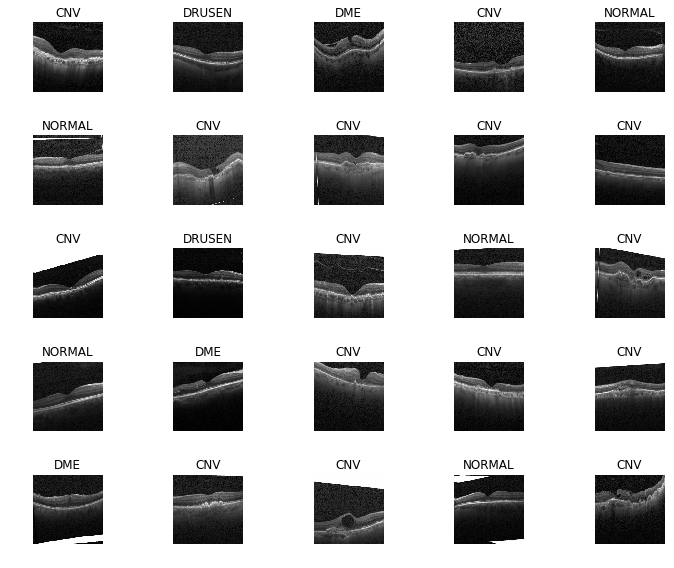

In [5]:
data.show_batch(rows=5, figsize=(10,8))

In [6]:
classes = data.classes
print(classes)

['CNV', 'DME', 'DRUSEN', 'NORMAL']


## Learning

#### First 10 epochs on last layer

In [7]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [8]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate
1,0.461799,0.344243,0.126138
2,0.296308,0.217875,0.073431
3,0.238851,0.176891,0.061572
4,0.203448,0.147849,0.047556
5,0.185176,0.142574,0.046239
6,0.176892,0.129132,0.043124
7,0.167862,0.124970,0.039890
8,0.168744,0.119069,0.038452
9,0.151654,0.118854,0.037734
10,0.162428,0.118828,0.038093


In [9]:
learn.save('retina-1')

In [10]:
#learn.load('retina-1')

#### Next 10 epochs unfreezing all the weights

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


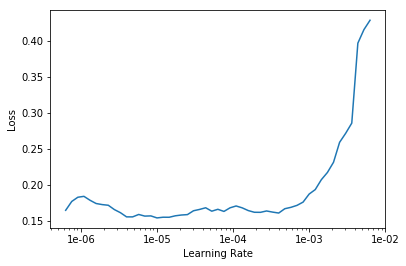

In [11]:
learn.unfreeze()
#learn.freeze_to(-10)
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(10, max_lr=slice(2e-6,4e-6))

epoch,train_loss,valid_loss,error_rate
1,0.153076,0.119181,0.037015
2,0.150209,0.115011,0.035098
3,0.150562,0.111978,0.034739
4,0.123776,0.108680,0.033541
5,0.138525,0.104307,0.032942
6,0.130011,0.104289,0.032463
7,0.116734,0.102480,0.032822
8,0.127978,0.101865,0.032343
9,0.136235,0.101717,0.032583
10,0.123808,0.101696,0.032223


In [13]:
learn.save('retina-2')

In [14]:
#learn.load('retina-2')

### Confusion matrix on the validation set

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

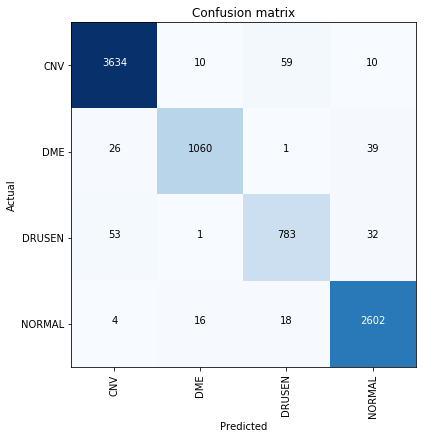

In [16]:
interp.plot_confusion_matrix(figsize=(6,6))

In [17]:
cm = interp.confusion_matrix()
print(pd.DataFrame(cm, columns=[classes], index=[classes]).to_string())

         CNV   DME DRUSEN NORMAL
CNV     3634    10     59     10
DME       26  1060      1     39
DRUSEN    53     1    783     32
NORMAL     4    16     18   2602


#### Confusion matrix for classes with issues, normalizing by row

In [18]:
cm_norm = (cm.T/(cm.sum(axis=1))).T
print(pd.DataFrame(cm_norm, columns=[classes], index=[classes]).round(2).to_string())

         CNV   DME DRUSEN NORMAL
CNV     0.98  0.00   0.02   0.00
DME     0.02  0.94   0.00   0.03
DRUSEN  0.06  0.00   0.90   0.04
NORMAL  0.00  0.01   0.01   0.99


#### Confusion matrix for classes with issues, normalizing by column

In [19]:
cm_norm = (cm/(cm.sum(axis=0)))
print(pd.DataFrame(cm_norm, columns=[classes], index=[classes]).round(2).to_string())

         CNV   DME DRUSEN NORMAL
CNV     0.98  0.01   0.07   0.00
DME     0.01  0.98   0.00   0.01
DRUSEN  0.01  0.00   0.91   0.01
NORMAL  0.00  0.01   0.02   0.97


#### Accuracy

In [20]:
print("accuracy:", (cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3])/cm.sum())

accuracy: 0.9677767129851461


## Now predict on Test set

In [21]:
src = (ImageItemList.from_folder(path, folder='.', suffix='.jpg') 
       .split_by_folder(train='train', valid='test')
       .label_from_folder())

data = (src.transform(get_transforms(flip_vert=True), size=224, bs=32)
        .databunch().normalize(imagenet_stats))

In [22]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 1000


In [23]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [25]:
learn.load('/home/jupyter/.fastai/data/retina/all_data/OCT2017 /train/models/retina-2') 

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (83484 items)
[Category CNV, Category CNV, Category CNV, Category CNV, Category CNV]...
Path: /home/jupyter/.fastai/data/retina/all_data/OCT2017 
x: ImageItemList (83484 items)
[Image (3, 496, 512), Image (3, 496, 1536), Image (3, 496, 768), Image (3, 496, 512), Image (3, 496, 768)]...
Path: /home/jupyter/.fastai/data/retina/all_data/OCT2017 ;

Valid: LabelList
y: CategoryList (1000 items)
[Category CNV, Category CNV, Category CNV, Category CNV, Category CNV]...
Path: /home/jupyter/.fastai/data/retina/all_data/OCT2017 
x: ImageItemList (1000 items)
[Image (3, 496, 512), Image (3, 496, 512), Image (3, 496, 512), Image (3, 496, 768), Image (3, 496, 512)]...
Path: /home/jupyter/.fastai/data/retina/all_data/OCT2017 ;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

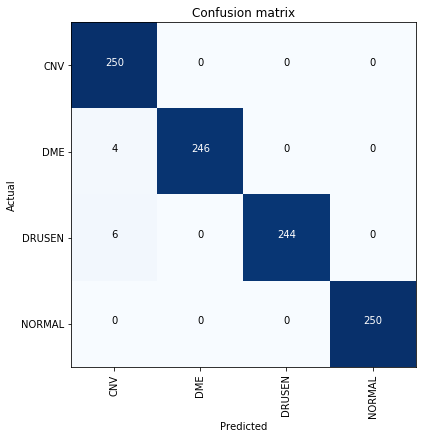

In [27]:
interp.plot_confusion_matrix(figsize=(6,6))

#### Confusion matrix for classes with issues, normalizing by row

In [28]:
cm = interp.confusion_matrix()
cm_norm = (cm.T/(cm.sum(axis=1))).T
print(pd.DataFrame(cm_norm, columns=[classes], index=[classes]).round(2).to_string())

         CNV   DME DRUSEN NORMAL
CNV     1.00  0.00   0.00    0.0
DME     0.02  0.98   0.00    0.0
DRUSEN  0.02  0.00   0.98    0.0
NORMAL  0.00  0.00   0.00    1.0


#### Confusion matrix for classes with issues, normalizing by column

In [29]:
cm_norm = (cm/(cm.sum(axis=0)))
print(pd.DataFrame(cm_norm, columns=[classes], index=[classes]).round(2).to_string())

         CNV  DME DRUSEN NORMAL
CNV     0.96  0.0    0.0    0.0
DME     0.02  1.0    0.0    0.0
DRUSEN  0.02  0.0    1.0    0.0
NORMAL  0.00  0.0    0.0    1.0


#### Accuracy

In [30]:
print("accuracy:", (cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3])/cm.sum())

accuracy: 0.99
